# Environment Setup

In [3]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git
!pip install scikit-learn
!pip install openpyxl

# Data Preprocessing & Visualisatie

Vorm van de data: (139, 494)
Kolommen: ['PREDICT_original_sf_compactness_avg_2.5D', 'PREDICT_original_sf_compactness_std_2.5D', 'PREDICT_original_sf_rad_dist_avg_2.5D', 'PREDICT_original_sf_rad_dist_std_2.5D', 'PREDICT_original_sf_roughness_avg_2.5D', 'PREDICT_original_sf_roughness_std_2.5D', 'PREDICT_original_sf_convexity_avg_2.5D', 'PREDICT_original_sf_convexity_std_2.5D', 'PREDICT_original_sf_cvar_avg_2.5D', 'PREDICT_original_sf_cvar_std_2.5D', 'PREDICT_original_sf_prax_avg_2.5D', 'PREDICT_original_sf_prax_std_2.5D', 'PREDICT_original_sf_evar_avg_2.5D', 'PREDICT_original_sf_evar_std_2.5D', 'PREDICT_original_sf_solidity_avg_2.5D', 'PREDICT_original_sf_solidity_std_2.5D', 'PREDICT_original_sf_area_avg_2.5D', 'PREDICT_original_sf_area_max_2.5D', 'PREDICT_original_sf_area_min_2.5D', 'PREDICT_original_sf_area_std_2.5D', 'PREDICT_original_sf_volume_2.5D', 'PREDICT_original_of_theta_x', 'PREDICT_original_of_theta_y', 'PREDICT_original_of_theta_z', 'PREDICT_original_hf_min', 'PREDICT_origin

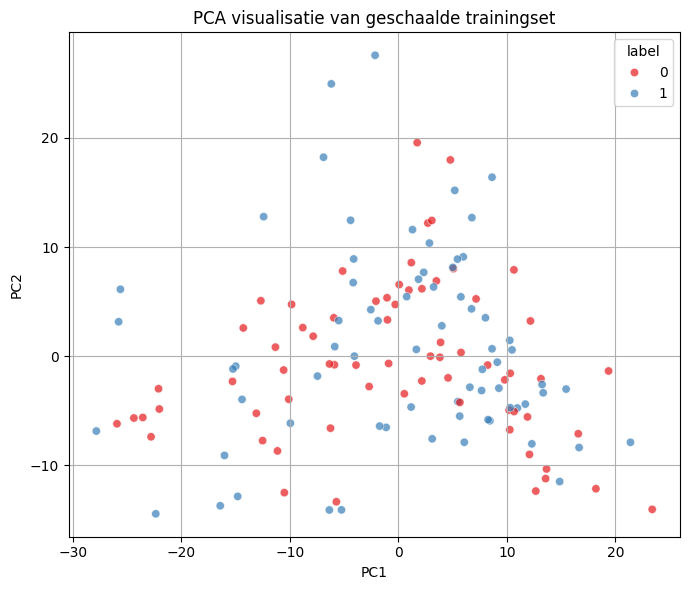

In [ ]:
# 📦 Vereiste imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# 🧾 Stap 1 – Laad de data
data = pd.read_excel("..\TrainData.xlsx")

# 🔍 Eerste inspectie
print("Vorm van de data:", data.shape)
print("Kolommen:", data.columns.tolist())
print("Aantal duplicaten:", data.duplicated().sum())
print("Missende waarden per kolom:")
print(data.isnull().sum())

# 🧼 Stap 2 – Dubbele rijen verwijderen
data = data.drop_duplicates()

# 🎯 Stap 3 – Split in features en labels
X = data.drop(columns="label")
y = data["label"]

# 🔁 Zet y om naar numeriek met behoud van pandas Series
label_encoder = LabelEncoder()
y = pd.Series(label_encoder.fit_transform(y), index=y.index)

# ❓ Hoeveel missende waarden blijven over?
print("Totaal aantal missende waarden:", X.isnull().sum().sum())

# ⚠️ Stap 4 – NaNs imputer (mediaan)
X = X.fillna(X.median(numeric_only=True))

# 📊 Evaluatie via meerdere metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc'
}

# ⚖️ Stap 6 – Balans controleren
print("\nLabelverdeling in training set:\n", y.value_counts(normalize=True))

# 📉 Stap 7 – PCA visualisatie 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["label"] = y.values  # y_train is een Series, dus .values werkt nu

plt.figure(figsize=(7, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="label", palette="Set1", alpha=0.7)
plt.title("PCA visualisatie van geschaalde trainingset")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


# 1. Randomized Search

In [5]:
import numpy as np
from pprint import pprint

# Define the hyperparameter ranges for RandomForestClassifier

# 1. Number of trees in the forest
n_estimators = [int(x) for x in np.linspace(start=5, stop=100, num=20)]

# 2. Number of features to consider at every split
max_features = np.linspace(0.1, 1.0, num=10)
max_features = np.round(max_features, 1).tolist()   # Round each number to one decimal place

# 3. Maximum number of levels in a tree
max_depth = [1, 2, 3, 4, 5, 7, 9, 11, 13, 15, 1000]    #1000 as unlimited depth (None can't be plotted)

# 4. Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5, 7, 9, 11, 13, 15, 20]

# 5. Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5, 7, 9, 11, 13, 15,]

# 6. Splitting criterion
criterion = ["gini", "entropy"]

# Create the random grid of hyperparameters
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'criterion': criterion
}

# Print the random grid for inspection
pprint(random_grid)


{'criterion': ['gini', 'entropy'],
 'max_depth': [1, 2, 3, 4, 5, 7, 9, 11, 13, 15, 1000],
 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
 'min_samples_leaf': [1, 2, 3, 4, 5, 7, 9, 11, 13, 15],
 'min_samples_split': [2, 3, 4, 5, 7, 9, 11, 13, 15, 20],
 'n_estimators': [5,
                  10,
                  15,
                  20,
                  25,
                  30,
                  35,
                  40,
                  45,
                  50,
                  55,
                  60,
                  65,
                  70,
                  75,
                  80,
                  85,
                  90,
                  95,
                  100]}


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import joblib

# Create the base RandomForestRegressor model to tune
rf = RandomForestClassifier(bootstrap=True)

# Use the random grid (defined previously) to search for the best hyperparameters.
# We perform a random search over 5000 different combinations, using 5-fold cross-validation.
# Verbose=2 displays progress details, random_state ensures reproducibility,
# and n_jobs=-1 utilizes all available CPU cores.
rf_random = RandomizedSearchCV(
    estimator=rf,                # The base model
    param_distributions=random_grid,  # The grid of hyperparameters to sample from
    n_iter=5000,                  # Number of parameter settings that are sampled
    cv=5,                        # 5-fold cross-validation
    verbose=2,                   # Verbosity level for logging progress
    random_state=42,             # For reproducibility ------> moet dit erbij???
    n_jobs=-1,                    # Use all available cores for parallel processing
    scoring='roc_auc'            # ROC AUC as scoring method
)

# save the results of the RandomizedSearchCV
joblib.dump(rf_random, "rf_random_search.pkl")

# Fit the random search model on the training data
rf_random.fit(X_scaled, y)


Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


KeyboardInterrupt: 

In [ ]:
# Print the best hyperparameters found during the search
print("Best Hyperparameters found: ", rf_random.best_params_)

# Print the best score achieved during the random search
print("Best score (AUC or accuracy, depending on the scoring used): ", rf_random.best_score_)

# Print the best estimator (the best model with the chosen hyperparameters)
print("Best estimator (model): ", rf_random.best_estimator_)

# Optionally, print the top 10 results based on the mean test score
results_df = pd.DataFrame(rf_random.cv_results_)
top_results = results_df[['param_n_estimators','param_max_features','param_max_depth','param_min_samples_split','param_min_samples_leaf','param_criterion', 'mean_test_score']]
print("\nTop 10 results:")
print(top_results.sort_values(by='mean_test_score', ascending=False).head(10))

print("\nWorst 10 results:")
print(top_results.sort_values(by='mean_test_score', ascending=False).tail(10))

Best Hyperparameters found:  {'n_estimators': 15, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 0.4, 'max_depth': 7, 'criterion': 'entropy'}
Best score (AUC or accuracy, depending on the scoring used):  0.821193092621664
Best estimator (model):  RandomForestClassifier(criterion='entropy', max_depth=7, max_features=0.4,
                       min_samples_leaf=4, min_samples_split=9,
                       n_estimators=15)

Top 10 results:
      param_n_estimators  param_max_features  param_max_depth  \
1084                  15                 0.4                7   
493                   60                 0.3                5   
231                   25                 0.7               13   
3645                  35                 0.3             1000   
2499                  55                 0.2                9   
4501                  40                 1.0               13   
1862                  80                 0.1                7   
1748                 

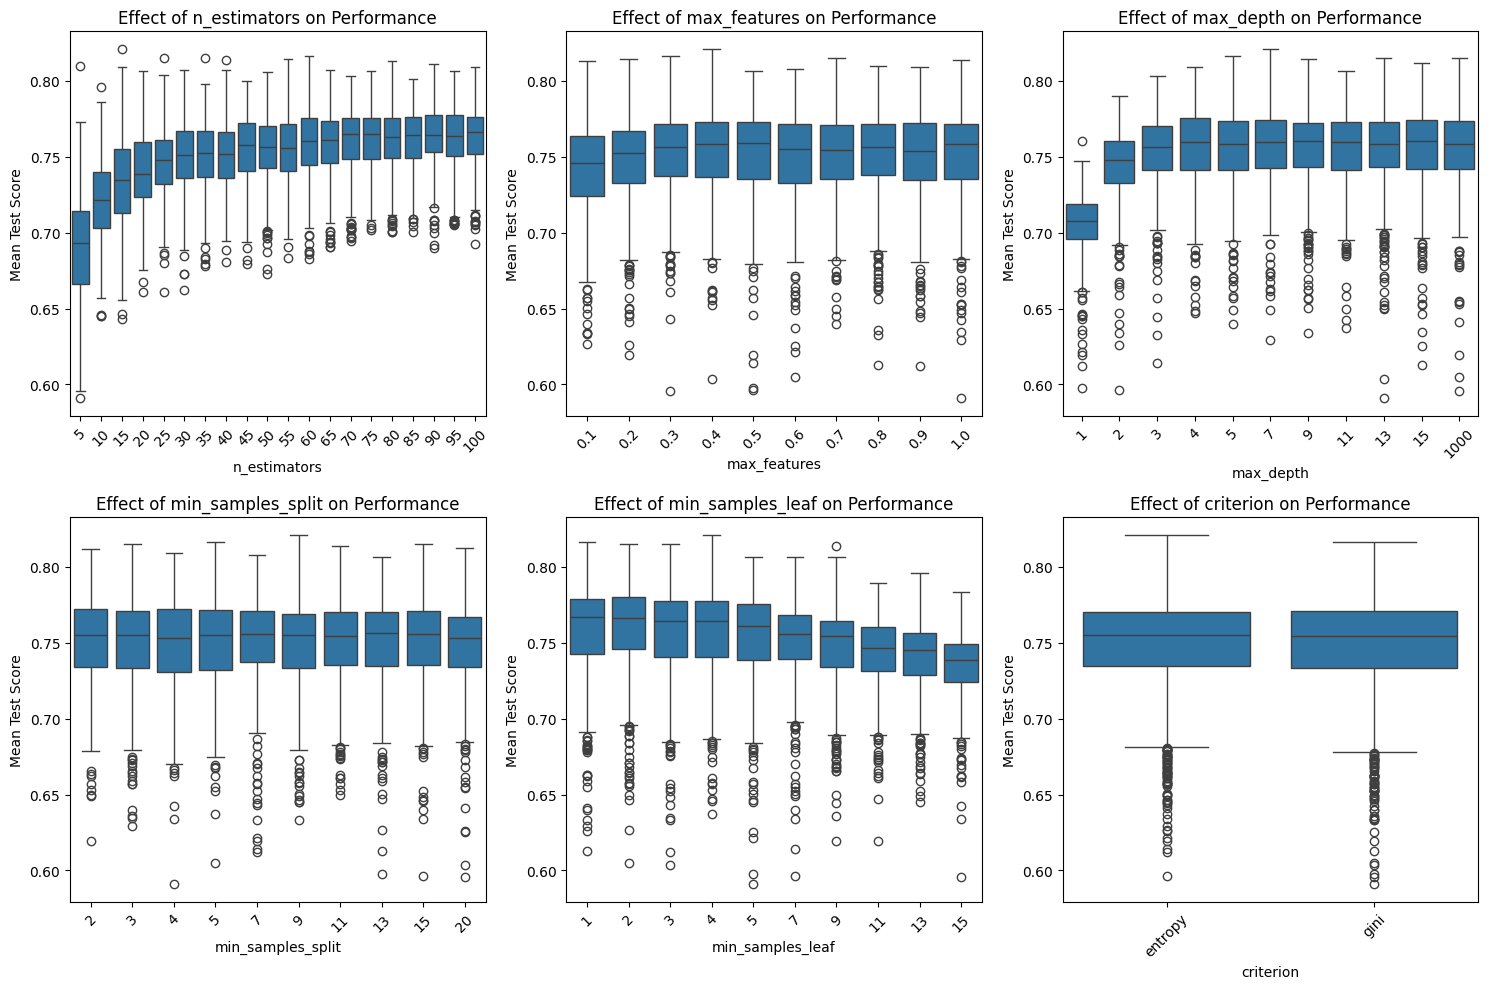

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert results to DataFrame
random_search_results = pd.DataFrame(rf_random.cv_results_)
random_search_results = random_search_results.sort_values(by="mean_test_score", ascending=False)

# List of hyperparameters to visualize
params = ["param_n_estimators", "param_max_features", "param_max_depth", "param_min_samples_split", "param_min_samples_leaf","param_criterion"]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

# Plot each hyperparameter against mean test score
for i, param in enumerate(params):
    sns.boxplot(x=random_search_results[param], y=random_search_results["mean_test_score"], ax=axes[i])
    axes[i].set_xlabel(param.replace("param_", ""))
    axes[i].set_ylabel("Mean Test Score")
    axes[i].set_title(f"Effect of {param.replace('param_', '')} on Performance")
    axes[i].tick_params(axis='x', rotation=45)

# Hide empty subplot if params < 6
if len(params) < len(axes):
    axes[-1].axis('off')

# Save the plot as an image file
plt.savefig('randomized_search_results2.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


# 2. Grid Search

In [ ]:
# Model selection
# Importeren van de benodigde libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Instellen van de hyperparameter grid voor GridSearchCV
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start=30, stop=60, num=15)],  # Aantal bomen
    'max_features': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
    'max_depth': [4, 5, 6, 7, 8],  # Diepte van de bomen
    'min_samples_split': [4, 5, 6, 7, 8],  # Minimale samples om een interne split te maken
    'min_samples_leaf': [1, 2, 3],  # Minimale samples in een bladknoop
    'criterion': ['gini'],  # Split criterium
}

# Print the random grid for inspection
pprint(param_grid)

{'criterion': ['gini'],
 'max_depth': [4, 5, 6, 7, 8],
 'max_features': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 'min_samples_leaf': [1, 2, 3],
 'min_samples_split': [4, 5, 6, 7, 8],
 'n_estimators': [30, 32, 34, 36, 38, 40, 42, 45, 47, 49, 51, 53, 55, 57, 60]}


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import joblib

# Maak een RandomForestClassifier model
rf = RandomForestClassifier(random_state=42)

# GridSearchCV instellen om de beste parameters te vinden
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='roc_auc')

# save the results of the GridSearchCV
rf_random = joblib.load("rf_grid_search.pkl")

# Trainen van het model met GridSearchCV
grid_search.fit(X_scaled, y)

# Toon de beste hyperparameters
print(f"Beste hyperparameters: {grid_search.best_params_}")

# Optionally, print the top 10 results based on the mean test score
results_df = pd.DataFrame(grid_search.cv_results_)
top_results = results_df[['param_n_estimators','param_max_features','param_max_depth','param_min_samples_split','param_min_samples_leaf','param_criterion', 'mean_test_score']]
print("\nTop 10 results:")
print(top_results.sort_values(by='mean_test_score', ascending=False).head(10))

print("\nWorst 10 results:")
print(top_results.sort_values(by='mean_test_score', ascending=False).tail(10))

NameError: name 'param_grid' is not defined

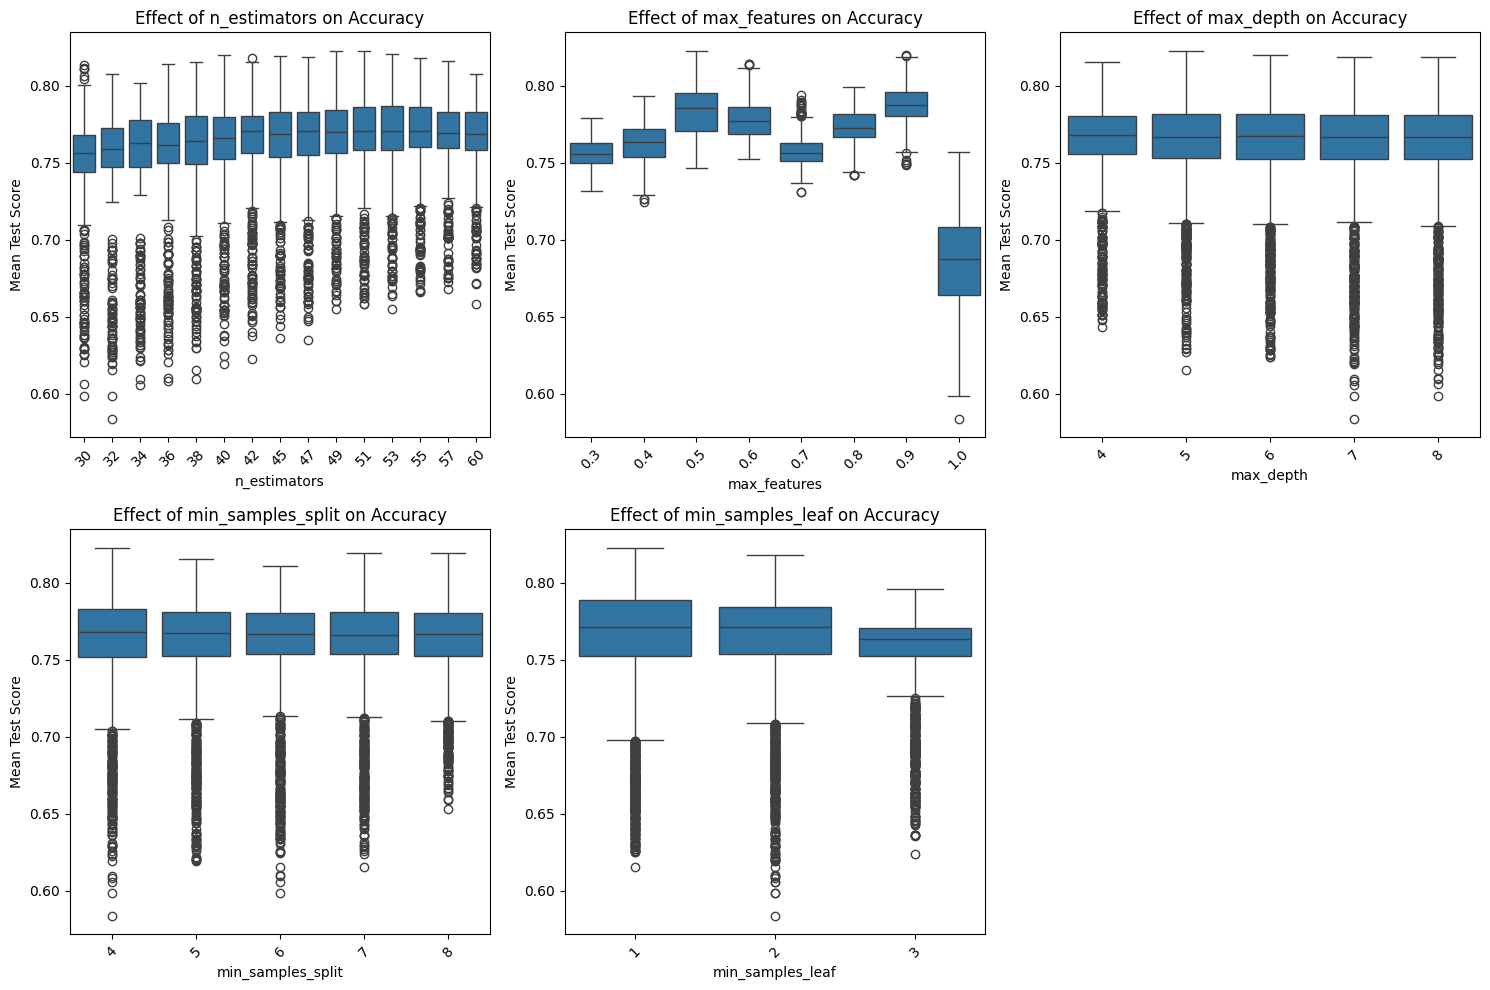

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert GridSearchCV results to DataFrame
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values(by="mean_test_score", ascending=False)

# Define hyperparameters to visualize
params = ["param_n_estimators", "param_max_features", "param_max_depth",'param_min_samples_split',
           "param_min_samples_leaf"]

# Create subplots for each hyperparameter
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Adjust grid size
axes = axes.flatten()  # Flatten for easy iteration

for i, param in enumerate(params):
    sns.boxplot(x=cv_results[param], y=cv_results["mean_test_score"], ax=axes[i])
    axes[i].set_xlabel(param.replace("param_", ""))
    axes[i].set_ylabel("Mean Test Score")
    axes[i].set_title(f"Effect of {param.replace('param_', '')} on Accuracy")
    axes[i].tick_params(axis='x', rotation=45)  # Rotate labels for readability

# Hide empty subplot if parameters < 6
if len(params) < len(axes):
    axes[-1].axis('off')

# Save the plot as an image file
plt.savefig('grid_search_results.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()



In [ ]:
best_model = grid_search.best_estimator_
print("Best Model:", best_model)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_roc_auc = grid_search.best_score_
print(f"Best Cross-Validation ROC AUC: {best_roc_auc:.4f}")

Best Model: RandomForestClassifier(max_depth=5, max_features=0.5, min_samples_split=4,
                       n_estimators=51, random_state=42)
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 51}
Best Cross-Validation ROC AUC: 0.8227


# Test on testdata

In [ ]:
# 📦 Vereiste imports
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 🧾 Stap 1 – Laad de data
test_data = pd.read_excel("..\TestData.xlsx")

# 🔍 Eerste inspectie
print("Vorm van de data:", test_data.shape)
print("Kolommen:", test_data.columns.tolist())
print("Aantal duplicaten:", test_data.duplicated().sum())
print("Missende waarden per kolom:")
print(test_data.isnull().sum())

# 🧼 Stap 2 – Dubbele rijen verwijderen
test_data = test_data.drop_duplicates()

# 🎯 Stap 3 – Split in features en labels
X_test = test_data.drop(columns="label")
y_test = test_data["label"]

# 🔁 Zet y om naar numeriek met behoud van pandas Series
label_encoder = LabelEncoder()
y_test = pd.Series(label_encoder.fit_transform(y_test), index=y_test.index)

# ❓ Hoeveel missende waarden blijven over?
print("Totaal aantal missende waarden:", X_test.isnull().sum().sum())

# ⚠️ Stap 4 – NaNs imputer (mediaan)
X_test = X_test.fillna(X_test.median(numeric_only=True))

# sc
X_test_scaled = scaler.fit_transform(X_test)

Vorm van de data: (47, 494)
Kolommen: ['PREDICT_original_sf_compactness_avg_2.5D', 'PREDICT_original_sf_compactness_std_2.5D', 'PREDICT_original_sf_rad_dist_avg_2.5D', 'PREDICT_original_sf_rad_dist_std_2.5D', 'PREDICT_original_sf_roughness_avg_2.5D', 'PREDICT_original_sf_roughness_std_2.5D', 'PREDICT_original_sf_convexity_avg_2.5D', 'PREDICT_original_sf_convexity_std_2.5D', 'PREDICT_original_sf_cvar_avg_2.5D', 'PREDICT_original_sf_cvar_std_2.5D', 'PREDICT_original_sf_prax_avg_2.5D', 'PREDICT_original_sf_prax_std_2.5D', 'PREDICT_original_sf_evar_avg_2.5D', 'PREDICT_original_sf_evar_std_2.5D', 'PREDICT_original_sf_solidity_avg_2.5D', 'PREDICT_original_sf_solidity_std_2.5D', 'PREDICT_original_sf_area_avg_2.5D', 'PREDICT_original_sf_area_max_2.5D', 'PREDICT_original_sf_area_min_2.5D', 'PREDICT_original_sf_area_std_2.5D', 'PREDICT_original_sf_volume_2.5D', 'PREDICT_original_of_theta_x', 'PREDICT_original_of_theta_y', 'PREDICT_original_of_theta_z', 'PREDICT_original_hf_min', 'PREDICT_origina


Evaluation on TestData:
Accuracy: 0.745
ROC-AUC: 0.804
F1-Score: 0.739


<Figure size 640x480 with 0 Axes>

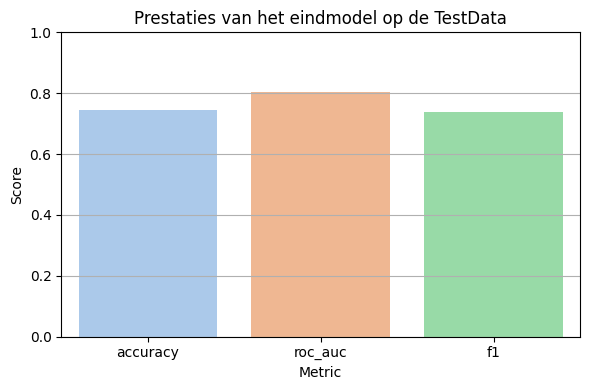

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# Evaluate best model on TestData
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)

print("\nEvaluation on TestData:")
print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred):.3f}")
print(f"ROC-AUC: {metrics.roc_auc_score(y_test, y_pred_proba[:, 1]):.3f}")
print(f"F1-Score: {metrics.f1_score(y_test, y_pred):.3f}")

# 🔍 Barplot voor prestaties op TestData
test_scores = {
    "accuracy": metrics.accuracy_score(y_test, y_pred),
    "roc_auc": metrics.roc_auc_score(y_test, y_pred_proba[:, 1]),
    "f1": metrics.f1_score(y_test, y_pred)
}

# Maak een DataFrame van de test_scores dictionary
df_scores = pd.DataFrame(list(test_scores.items()), columns=["Metric", "Score"])

# Save the plot as an image file
plt.savefig('test_scores.png', dpi=300, bbox_inches='tight')

plt.figure(figsize=(6, 4))
sns.barplot(x="Metric", y="Score", data=df_scores, hue="Metric", dodge=False, palette="pastel")
plt.legend([], [], frameon=False)  # Zet de legende uit
plt.ylim(0, 1)
plt.title("Prestaties van het eindmodel op de TestData")
plt.ylabel("Score")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()


# Create more testsets?

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load FullDataset
file_path = "FullDataset.xlsx"
df = pd.read_excel(file_path)

# Split data into features (X) and target (y)
X = df.drop(columns=["label"])  # assuming "label" is the target column
y = df["label"]

# Split data into training and testing sets (5 test sets)
test_size = 0.2  # adjust this value to change the proportion of test data
  # adjust this value to change the random seed

test_sets = []
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    test_set = pd.concat([X_test, y_test], axis=1)
    test_sets.append(test_set)

# Save each test set to a separate Excel file
for i, test_set in enumerate(test_sets):
    file_path = f"TestSet_{i+1}.xlsx"
    test_set.to_excel(file_path,index=False)